In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
class IrisDataset:
  def __init__(self, iris_csv):
    self.iris = pd.read_csv(iris_csv, header = 0).iloc[:100,:]
    self.features = self.iris.iloc[:,:-1]
    self.labels = self.iris.iloc[:,-1]
    self.preprocessing()

  @staticmethod
  def add_bias(X):
    if isinstance(X, pd.DataFrame):
      X = X.values
    bias = np.ones((X.shape[0],1))
    return np.concatenate([bias, X], axis = 1)

  def preprocessing(self):
    self.features = self.add_bias(self.features)

    map_dicts = {'setosa': 0, 'versicolor': 1}
    self.labels = self.labels.map(map_dicts).values.reshape(-1,1)

    from sklearn.model_selection import train_test_split
    self.f_train,  self.f_test, self.l_train,self.l_test = train_test_split(
        self.features,
        self.labels,
        train_size=0.7,
        random_state = 42,
        shuffle = True
    )

  def show(self):
    print(f"features's shape {self.f_train.shape}")
    print(self.f_train[:10,:])
    print(f"labels's shape {self.l_train.shape}")
    print(self.l_train[:10,:])



In [9]:
class LR_model:
    def __init__(self, f_train, l_train, epochs=100, lr=0.01, verbose=True):
        self.f_train = f_train
        self.l_train = l_train
        self.epochs = epochs
        self.lr = lr
        self.verbose = verbose
        self.eps = 1e-9
        self.losses = []

    def BCE(self, y, y_hat):
        y_hat = np.clip(y_hat, self.eps, 1 - self.eps)
        loss = np.mean(
            -y*np.log(y_hat) - (1-y)*np.log(1-y_hat)
        )
        self.losses.append(loss)
        return loss

    @staticmethod
    def stable_sigmoid(x):
        z = np.zeros_like(x)
        z[x >= 0] = 1 / (1 + np.exp(-x[x >= 0]))
        z[x < 0] = np.exp(x[x < 0])
        z[x < 0] = z[x < 0] / (1 + z[x < 0])
        return z

    def forward(self, X, W):
        return self.stable_sigmoid(X @ W)

    def backward(self, y_hat):
        m = self.f_train.shape[0]
        return (1/m) * self.f_train.T @ (y_hat - self.l_train)

    def train(self):
        m, n = self.f_train.shape
        self.W = np.random.randn(n, 1)

        pbar = tqdm(range(self.epochs))
        for epoch in pbar:
            y_hat = self.forward(self.f_train, self.W)
            loss = self.BCE(self.l_train, y_hat)
            grad = self.backward(y_hat)

            self.W -= self.lr * grad

            if self.verbose:
                pbar.set_description(f"loss: {loss:.6f}")

            if np.linalg.norm(grad) < self.eps:
                break

    def predict(self, features):
        out = self.forward(features, self.W)
        return (out >= 0.5).astype(int)

    def loss_curve(self):
      x_axis = range(len(self.losses))
      plt.plot(x_axis, self.losses, color = 'r')
      plt.show()


In [10]:
def prepare_data():
  dataset = IrisDataset('/content/iris.csv')
  return dataset.f_train, dataset.l_train, dataset.f_test, dataset.l_test


In [11]:
def main():
  f_train, l_train, f_test, l_test = prepare_data()
  model = LR_model(f_train, l_train, epochs  = 10000, lr = 0.01, verbose = True)
  model.train()
  predicts = model.predict(f_test)
  from sklearn.metrics import classification_report, accuracy_score
  acc = accuracy_score(l_test.ravel(), predicts.ravel())
  print('acc:',acc)
  print(classification_report(l_test, predicts))
  model.loss_curve()


loss: 0.008333: 100%|██████████| 10000/10000 [00:11<00:00, 870.09it/s]


acc: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



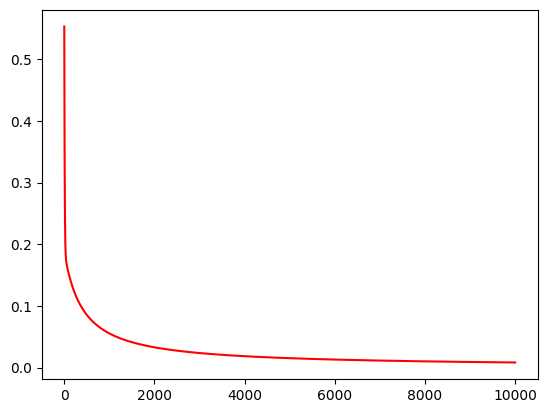

In [12]:
if __name__ == '__main__':
  main()